## 0. Definição de Bibliotecas e Funções Auxiliares

In [3]:
# Ignorar alertas
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier,DecisionTreeRegressor
from sklearn import metrics
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from skopt import BayesSearchCV
from skopt.space import Integer, Real
from sklearn import metrics
from sklearn.metrics import (f1_score,accuracy_score,recall_score,precision_score,confusion_matrix,roc_auc_score,mean_squared_error,r2_score)

## 1. Leitura dos Dados

In [4]:
df_medicoes = pd.read_csv('./data/BD_Linhas-de-Transmissão(Documentos de Medição).csv', encoding='latin-1', sep=';')
df_cadastro = pd.read_csv('./data/BD_Linhas-de-Transmissão(Cadastro).csv', encoding='latin-1', sep=';')

df_qualificacao = df_medicoes[df_medicoes['Item medição'] == 'TORRE']
df_medicoes = df_medicoes[df_medicoes['Item medição'] != 'TORRE']

In [5]:
df_qualificacao.head()

,Equipamento,Ponto medição,Doc.medição,Data,Item medição,Valor teórico,LimInfIntMed.,LimSupIntMed.,ValMed/PosTCont,Unid.caracter.,Cód.valorização,Txt.code codif.,Denominação,Texto
23,294939,9283757,7983160,18/02/2025,TORRE,NaN,"0,00",NaN,"5,00",UN,NaN,NaN,Qualificacao do Equipamento,D:0*1/ 0*2/ 0*3/ 0*4/ 2*5/ 165*9
24,294939,9283757,3692788,02/02/2022,TORRE,NaN,"0,00",NaN,"9,00",UN,NaN,NaN,Qualificacao do Equipamento,D:0*1/ 0*2/ 0*3/ 0*4/ 0*5/ 167*9
26,294938,9283589,7983161,18/02/2025,TORRE,NaN,"0,00",NaN,"4,00",UN,NaN,NaN,Qualificacao do Equipamento,ENTULHO. D:0*1/ 0*2/ 0*3/ 1*4/ 2*5/ 164*
27,294938,9283589,4758120,05/05/2023,TORRE,NaN,"0,00",NaN,"5,00",UN,NaN,NaN,Qualificacao do Equipamento,D:0*1/ 0*2/ 0*3/ 0*4/ 2*5/ 165*9
28,294938,9283589,3692787,02/02/2022,TORRE,NaN,"0,00",NaN,"9,00",UN,NaN,NaN,Qualificacao do Equipamento,D:0*1/ 0*2/ 0*3/ 0*4/ 0*5/ 167*9


In [6]:
df_medicoes.head()

,Equipamento,Ponto medição,Doc.medição,Data,Item medição,Valor teórico,LimInfIntMed.,LimSupIntMed.,ValMed/PosTCont,Unid.caracter.,Cód.valorização,Txt.code codif.,Denominação,Texto
0,323958,10155659,7991396,18/02/2025,VÃO,"0,00","0,00","100,00","1.500,00",m2,3.0,FIM DO VAO,ROCADA MECANIZADA,Roçada mecanizada no final do vão 50x30.
1,323957,10155490,7991397,18/02/2025,VÃO,"0,00","0,00","100,00","5.400,00",m2,1.0,INICIO DO VAO,ROCADA MANUAL,Roçada manual no início do vão 180x30. R
2,323957,10155491,7991398,18/02/2025,VÃO,"0,00","0,00","100,00","3.600,00",m2,5.0,MEIO E FIM DO VAO,ROCADA MECANIZADA,Roçada mecanizada no meio e fim do vão 1
3,323955,10155322,7991399,18/02/2025,VÃO,"0,00","0,00","100,00","6.000,00",m2,5.0,MEIO E FIM DO VAO,ROCADA MANUAL,Roçada manual no meio e fim do vão 200x3
4,323954,10155155,7991400,18/02/2025,VÃO,"0,00","0,00","100,00","10.350,00",m2,7.0,VAO COMPLETO,ROCADA MECANIZADA,Roçada mecanizada vão total 345x30. Rel


In [7]:
df_cadastro.head()

,Equipamento,Linha de Transmissão,Denominação,Dt.entr.serviço,Classe,Código ABC,Tensão,Latitude,Longitude
0,115280,LT31,Torre 111,NaN,L_TORRE_AUTOPORT,C,230,"-22,9776099","-50,0565232"
1,115281,LT31,Torre 112,NaN,L_TORRE_AUTOPORT,C,230,"-22,9791718","-50,0531681"
2,115282,LT31,Torre 113,NaN,L_TORRE_AUTOPORT,C,230,"-22,9808738","-50,0494992"
3,115283,LT31,Torre 114,NaN,L_TORRE_AUTOPORT,C,230,"-22,9830172","-50,0449193"
4,115284,LT31,Torre 115,NaN,L_TORRE_AUTOPORT,C,230,"-22,9846747","-50,0413489"


## 2. Analise de Dados Faltantes

### 2.1. Dados Faltes na Base de Cadastro

Nessa seção, descrevemos os dados faltantes na base de dados de cadastro. A maior parte dos dados faltantes se concentra em Latitude e Longitudade e mais algumas poucas classes faltantes

In [12]:
del df_cadastro['Dt.entr.serviço']

df_cadastro['Latitude'] = df_cadastro['Latitude'].replace('#N/D', pd.NA)
df_cadastro['Longitude'] = df_cadastro['Longitude'].replace('#N/D', pd.NA)

df_cadastro['Latitude'] = df_cadastro['Latitude'].apply(lambda x: float(str(x).replace(',', '.')) if pd.notna(x) else x)
df_cadastro['Longitude'] = df_cadastro['Longitude'].apply(lambda x: float(str(x).replace(',', '.')) if pd.notna(x) else x)


KeyError: 'Dt.entr.serviço'

In [13]:
lista_info = []
for elem in list(df_cadastro.columns):
    lista = df_cadastro[elem].sort_values(ascending = True).unique().tolist()
    lista_info.append((len(lista),df_cadastro[elem].sort_values(ascending = True).isnull().sum(),round(df_cadastro[elem].sort_values(ascending = True).isnull().sum()/df_cadastro.shape[0]*100,2)))

df_infos_features = pd.DataFrame(data = lista_info, columns = ["Total","Null","Percentual"], index = list(df_cadastro.columns))


In [15]:
display(df_infos_features)

,Total,Null,Percentual
Equipamento,36229,0,0.00
Linha de Transmissão,272,0,0.00
Denominação,1885,0,0.00
Classe,9,227,0.63
Código ABC,2,0,0.00
Tensão,8,0,0.00
Latitude,31284,4839,13.36
Longitude,31289,4839,13.36


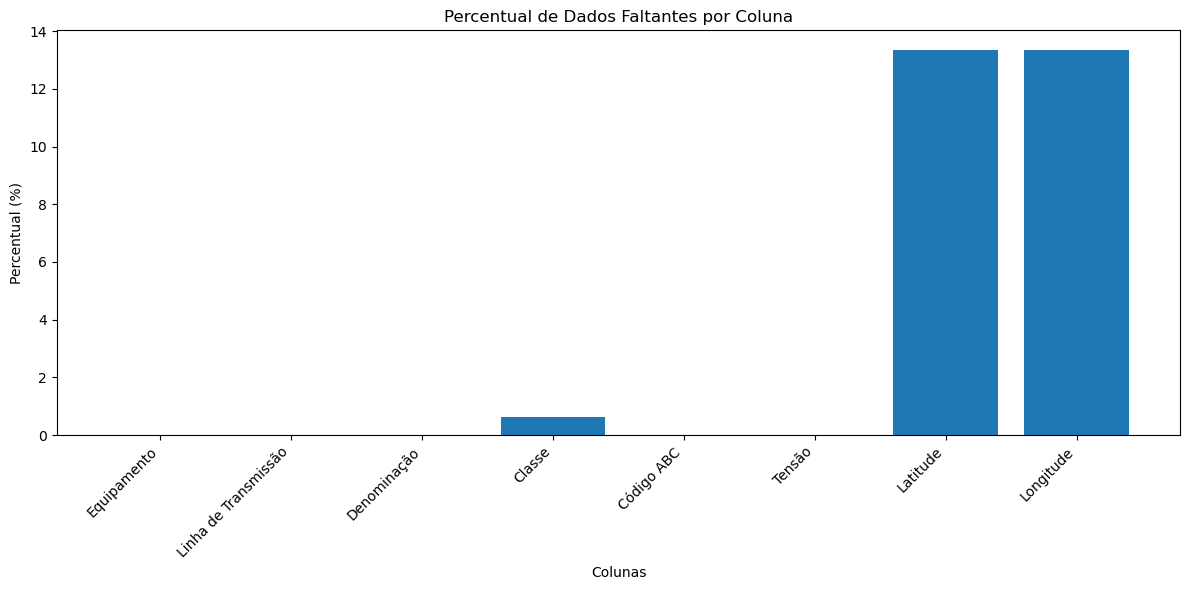

In [16]:
plt.figure(figsize=(12, 6))
plt.bar(df_infos_features.index, df_infos_features['Percentual'])
plt.title('Percentual de Dados Faltantes por Coluna')
plt.xlabel('Colunas')
plt.ylabel('Percentual (%)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


### 2.2 Tratamento de Dados Ausentes da Columa **Campo**

Para lidar com os dados ausentes da coluna campo, treinamento um modelo de aprendizado de maquina para prever a classe da torre usando as outras informações do cadastro.

In [16]:
feature_cols = ['Linha de Transmissão','Denominação','Código ABC','Tensão'] 
X = df_cadastro[feature_cols] # Features

le = LabelEncoder()
y = df_cadastro['Classe'][df_cadastro['Classe'].notnull()]
y_encoded = le.fit_transform(y)

encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
X_encoded = encoder.fit_transform(X)

indices_not_null = y.index.tolist()
X_encoded_not_null = X_encoded[indices_not_null]

X_train, X_test, y_train, y_test = train_test_split(X_encoded_not_null, y_encoded, test_size=0.3, random_state=42) # 70% training and 30% test

In [20]:
clf = DecisionTreeClassifier(random_state=42)

search_spaces = {
    'max_depth': Integer(1, 66),
    'min_samples_split': Integer(2, 6),
    'min_samples_leaf': Integer(1, 6),
    'max_features': Real(0.1, 1.0, prior='uniform')
}

opt = BayesSearchCV(
    estimator=clf,
    search_spaces=search_spaces,
    n_iter=32,  # número de iterações de busca
    scoring='neg_mean_squared_error',
    cv=3,
    random_state=42
)

# Executar a busca
opt.fit(X_train, y_train)

# Melhor hiperparâmetro encontrado
print("Melhores hiperparâmetros:", opt.best_params_)

In [23]:
def performance_modelo_classificacao(y_train,y_test,pred_train,pred_val):
     
    # Lista para armazenar os resultados de Treino e Validação
    score_list = []
     
    # Acurácia do modelo
    train_acc = accuracy_score(y_train, pred_train)
    val_acc = accuracy_score(y_test, pred_val)
     
    # Recall do modelo 
    train_recall = recall_score(y_train, pred_train,average = 'micro')
    val_recall = recall_score(y_test, pred_val,average = 'micro')
     
    # Precisão do modelo
    train_prec = precision_score(y_train, pred_train,average = 'micro')
    val_prec = precision_score(y_test, pred_val,average = 'micro')
     
    # F1-Score do modelo
    train_f1 = f1_score(y_train, pred_train, average = 'micro')
    val_f1 = f1_score(y_test, pred_val, average = 'micro')
     
    # Popula a lista
    score_list.extend((train_acc, val_acc, train_recall, val_recall, train_prec, val_prec, train_f1, val_f1))
     
    # Imprime a lista se flag=True (default)
    print(f'Acurácia na base de Treino: {train_acc}')
    print(f'Acurácia na base de Teste: {val_acc}')
    print(f'\nRecall na base de Treino: {train_recall}')
    print(f'Recall na base de Teste: {val_recall}')
    print(f'\nPrecisão na base de Treino: {train_prec}')
    print(f'Precisão na base de Teste: {val_prec}')
    print(f'\nF1-Score na base de Treino: {train_f1}')
    print(f'F1-Score na base de Teste: {val_f1}')
         
    return score_list


# Avaliar no conjunto de Treino
y_pred_train = opt.predict(X_train)

# Avaliar no conjunto de teste
y_pred_test = opt.predict(X_test)

# Métricas de performance da classificação
met_clas = performance_modelo_classificacao(y_train,y_test,y_pred_train,y_pred_test)


Acurácia na base de Treino: 0.9644061743581603
Acurácia na base de Teste: 0.9612072956207759

Recall na base de Treino: 0.9644061743581603
Recall na base de Teste: 0.9612072956207759

Precisão na base de Treino: 0.9644061743581603
Precisão na base de Teste: 0.9612072956207759

F1-Score na base de Treino: 0.9644061743581603
F1-Score na base de Teste: 0.9612072956207759


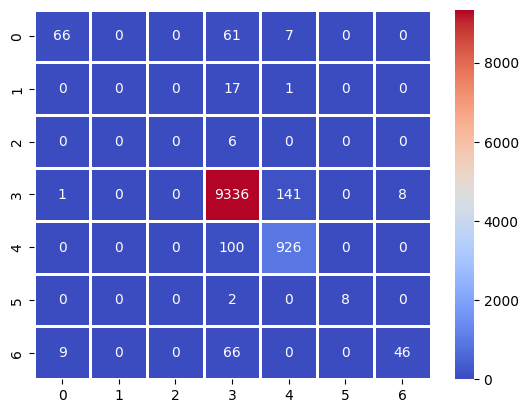

In [24]:
# Matriz de confusão
cf_matrix = confusion_matrix(y_test, y_pred_test)

# Criando o heatmap
sns.heatmap(cf_matrix, cmap='coolwarm', annot=True, linewidth=1, fmt='d')
plt.show()

### 2.3 Dados Faltes na Base de Medições

Nessa seção, vamos dividir a base de medições em duas partes: medições e qualificação. 

Na base de medições, vamos realizar algumas transformações e limpeza de dados, como a conversão de tipos de dados, tratamento de valores ausentes e padronização de colunas. Além disso, vamos garantir que os dados estejam prontos para análises posteriores, facilitando a identificação de padrões e a aplicação de modelos de machine learning.

Abaixo temos a quantidade de dados faltantes por coluna:

In [19]:
lista_info = []
for elem in list(df_medicoes.columns):
    lista = df_medicoes[elem].sort_values(ascending = True).unique().tolist()
    lista_info.append((len(lista),df_medicoes[elem].sort_values(ascending = True).isnull().sum(),round(df_medicoes[elem].sort_values(ascending = True).isnull().sum()/df_medicoes.shape[0]*100,2)))

df_infos_features = pd.DataFrame(data = lista_info, columns = ["Total","Null","Percentual"], index = list(df_medicoes.columns))

display(df_infos_features)


,Total,Null,Percentual
Equipamento,32021,0,0.00
Ponto medição,133209,0,0.00
Doc.medição,220418,0,0.00
Data,2108,0,0.00
Item medição,9,0,0.00
Valor teórico,5,0,0.00
LimInfIntMed.,1,0,0.00
LimSupIntMed.,5,0,0.00
ValMed/PosTCont,2389,958,0.39
Unid.caracter.,5,0,0.00


In [18]:
import matplotlib.pyplot as plt

missing_values = df_medicoes.isnull().sum()
missing_values


Equipamento           0
Ponto medição         0
Doc.medição           0
Data                  0
Item medição          0
Valor teórico         0
LimInfIntMed.         0
LimSupIntMed.         0
ValMed/PosTCont     958
Unid.caracter.        0
Cód.valorização    3574
Txt.code codif.    3574
Denominação           0
Texto              7063
dtype: int64

In [ ]:
plt.figure(figsize=(10,6))
missing_values.plot(kind='bar')
plt.title('Quantidade de Dados Faltantes por Coluna')
plt.ylabel('Quantidade de valores nulos')
plt.xlabel('Colunas')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Precisamos converter as colunas que são numeros, para o objeto numerico do python. Essa conversão se deve ao fato da tabela usar virgula para separação do decimal, quanto o python necessita de ponto.

In [26]:
colunas_para_converter = ['Valor teórico', 'LimInfIntMed.', 'LimSupIntMed.', 'ValMed/PosTCont']

for coluna in colunas_para_converter:
    df_medicoes[coluna] = df_medicoes[coluna].apply(
        lambda x: float(str(x).replace('.', '').replace(',', '.')) if pd.notna(x) else np.nan
    )



Para lidar com dados faltantes na coluna **ValMed/PosTCont**, verificamos se a amostra tem **TEXTO=5**, que indica que a medição está dentro dos limites e portanto, atribuimos como a média do intervalo previsto pelo fabricante.

In [27]:
# Se tiver faltando a medição e a qualificação for 5, então a medição é a média da faixa de medição.

aux_ = df_medicoes[df_medicoes['ValMed/PosTCont'].isna()]
aux_ = aux_[aux_['Texto'] == '5']
df_medicoes.loc[aux_.index, 'ValMed/PosTCont'] = (aux_['LimSupIntMed.'] - aux_['LimInfIntMed.'])/2


Para continaur lidando com dados faltantes na coluna **ValMed/PosTCont**, verificamos se a amostra tem **Txt.code codif.= "CONDIÇÃO NORMAL"**, que indica que a medição está dentro dos limites e portanto, atribuimos como a média do intervalo previsto pelo fabricante.

In [28]:
# Se tiver faltando a medição e a condição for normal, então a medição é a média da faixa de medição.


aux_ = df_medicoes[df_medicoes['ValMed/PosTCont'].isna()]
aux_ = aux_[aux_['Txt.code codif.'] == 'CONDIÇÃO NORMAL']
df_medicoes.loc[aux_.index, 'ValMed/PosTCont'] = (aux_['LimSupIntMed.'] - aux_['LimInfIntMed.'])/2


In [29]:
df_medicoes = df_medicoes[df_medicoes['ValMed/PosTCont'].notna()]

As variaveis que são complexas de serem preenchidas, como **Texto**, serão inputados como "Não Informado" ou "Desconhecido"

In [30]:
# Essas variaveis são complexas de serem preenchidas, então vamos preencher com valores desconhecidos.

df_medicoes['Txt.code codif.'] = df_medicoes['Txt.code codif.'].fillna('Desconhecido')
df_medicoes['Cód.valorização'] = df_medicoes['Cód.valorização'].fillna(-1)
df_medicoes['Texto'] = df_medicoes['Texto'].fillna('Não Informado')


In [31]:
df_medicoes.isnull().sum()

Equipamento        0
Ponto medição      0
Doc.medição        0
Data               0
Item medição       0
Valor teórico      0
LimInfIntMed.      0
LimSupIntMed.      0
ValMed/PosTCont    0
Unid.caracter.     0
Cód.valorização    0
Txt.code codif.    0
Denominação        0
Texto              0
dtype: int64

## 2.4 Dados Faltantes da Base de Qualificação

Podemos ver que existem dados de qualificação com dados faltantes no campo **Texto**, indicando a falta de algumas qualificações para as torres existentes.

In [32]:
del df_qualificacao['Valor teórico']
del df_qualificacao['LimInfIntMed.']
del df_qualificacao['LimSupIntMed.']
del df_qualificacao['Cód.valorização']
del df_qualificacao['Txt.code codif.']

In [37]:
df_qualificacao.isnull().sum()

Equipamento           0
Ponto medição         0
Doc.medição           0
Data                  0
Item medição          0
ValMed/PosTCont       0
Unid.caracter.        0
Denominação           0
Texto              9566
Ano                   0
Mes                   0
dtype: int64

## 2.5 Enriquecimento dos Dados de Medição

Com as colunas existantes, criamos as seguintes colunas para a base de medições:
- Separação da data de medição (Ano e Mês)
- Coluna que indica se a medição está dentro dos limites ou não.
- Desvio normalizado da medição. Mede o quanto a medição está fora dos padrões definidos e normaliza-a.

Com as colunas existantes, criamos as seguintes colunas para a base de qualificações:
- Separação da data de medição (Ano e Mês)


In [33]:
df_medicoes['Data'] = pd.to_datetime(df_medicoes['Data'], format='%d/%m/%Y', errors='coerce')
df_medicoes['Ano'] = df_medicoes['Data'].dt.year
df_medicoes['Mes'] = df_medicoes['Data'].dt.month

df_qualificacao['Data'] = pd.to_datetime(df_qualificacao['Data'], format='%d/%m/%Y', errors='coerce')
df_qualificacao['Ano'] = df_qualificacao['Data'].dt.year
df_qualificacao['Mes'] = df_qualificacao['Data'].dt.month


In [34]:
df_medicoes['inside_limits'] = (df_medicoes['ValMed/PosTCont'] >= df_medicoes['LimInfIntMed.']) & (df_medicoes['ValMed/PosTCont'] <= df_medicoes['LimSupIntMed.'])

In [35]:
# Calcula o índice de desvio em relação ao intervalo esperado
df_medicoes['desvio'] = 0  # Valor padrão para caso dentro dos limites

# Caso valor > limite_sup
mask_acima = df_medicoes['ValMed/PosTCont'] > df_medicoes['LimSupIntMed.']
df_medicoes.loc[mask_acima, 'desvio'] = (df_medicoes.loc[mask_acima, 'ValMed/PosTCont'] - 
                                         df_medicoes.loc[mask_acima, 'LimSupIntMed.']) / df_medicoes.loc[mask_acima, 'LimSupIntMed.']

# Caso valor < limite_inf
mask_abaixo = df_medicoes['ValMed/PosTCont'] < df_medicoes['LimInfIntMed.']
df_medicoes.loc[mask_abaixo, 'desvio'] = (df_medicoes.loc[mask_abaixo, 'ValMed/PosTCont'] - 
                                          df_medicoes.loc[mask_abaixo, 'LimInfIntMed.']) / (df_medicoes.loc[mask_abaixo, 'LimSupIntMed.'] - 
                                                                                           df_medicoes.loc[mask_abaixo, 'LimInfIntMed.'])

In [36]:
df_medicoes.to_csv("./processed_data/medicoes.csv", index=False)
df_qualificacao.to_csv("./processed_data/qualificacao.csv", index=False)
df_cadastro.to_csv("./processed_data/cadastro.csv", index=False)